

In this notebook we build upon fermion_spin_hopping_qutip to try and build a QPC meassuring a single/double dot system. Here, we model the QPC as a thighbinding model with equal hopping everywhere except where its is hooked up to the double dot system via a quartic interaction. **Here we include redundante degrees of freedome on purpose because we deal with Fermionic strings from the start, hence our hamiltonians will be of size $(2^2)(2^{L_{qpc}})\times (2^2)(2^{L_{qpc}})$**

In [17]:
import numpy as np

from scipy.integrate import simpson
from scipy import sparse

import matplotlib.pyplot as plt
import seaborn as sns
from qutip import  *
import os
import sys
import h5py
import json

import matplotlib

# add path to project dir so we can include custom modules from src
sys.path.append('../../scripts') 
from qutip_tools import *


In [18]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 18

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../plots/QPC_double_dot/"


In [19]:
# location where the raw data is saved
data_route = "../data/sims/"
fig_route = "../plots/QPC_double_dot/"

L_qpc = 14  # lenth of the QPC chain
L = L_qpc+2 # QPC times double dot 
max_t = 9 # maximum time
tsteps = 300 # number of time steps
bond_index = int(L_qpc/2) # dangling bond between bond_index and bond_index+1
centered_at = 0 # initial QPC position of wavepacket
band_width = 3.0 # width of the gaussian wave packet larger bandwidth means less lattice localizaiton
K0 = np.pi/2 # averga momentum of the wavepacket
J_prime = 1.0 # contact to double dot
t = 0.2 # hopping between quantum dots 
Omega = 0.0 # coupling between dot 1 and QPC
ddot = "momentum" # can be free, fixed (always close to 1) or momentum which is set by k0 based on af, bf
gamma = 0 # no dephasing actually but we put it here so we can reause the function
# in case we want to fix the state of the dot when it gets hit
phi = 0
af = np.sqrt(0.1)
bf = np.sqrt(1-af**2)
print(af,bf)

J = np.ones(L_qpc) # QPC hopping
# this means that I am putting the dangling bond between sites int(L_qpc/2) and int(L_qpc/2)+1
# where the interaction to the double dot is also located
J[bond_index] = J_prime  


0.31622776601683794 0.9486832980505138


# Functions

In [20]:
def gen_gauss_init(l0, sigma, Nsites, k0=0):
    # creates a gaussian initial condition centerd on l0 with bandwidth sigma for Nsites
    # and initial velocity k0

    x = np.asarray(range(0,Nsites))
    coefs = ((np.sqrt(np.pi)*sigma)**(-0.5))*np.exp(-0.5*(x-l0)**2/(sigma**2) )*np.exp(1j*k0*(x-l0))
    
    # normalize
    mag = np.dot(np.conjugate(coefs),coefs)
    coefs = coefs/np.sqrt(mag)
    
    return coefs    

def get_DD_init_for_fixed_k(k_prime):
    # calculated the initial conditions of the DD such that, when the QPC hits the bond
    # its state is the same as that of a DD initialized localized in the first site when 
    # the QPC for that case hits the bond with an average momentum k0=pi/2
    # k_prime: float. The momentum of the qpc particle
     
    alpha0 = np.cos( (t*bond_index)/(2*J[0])*(1/np.sin(k_prime) - 1) )
    beta0 = - 1j*np.sin( (t*bond_index)/(2*J[0])*(1/np.sin(k_prime) - 1) )
                        
    return alpha0, beta0

def get_partial_trace(Psi,NN):
    # calcualtes the partial trace from a STATEVECTOR Psi
    # NOT from the density matrix
    # Psi: Quobject from Qutip representing the wavefunction
    # NN: integer with the total size of the lattice

    n = 2**(NN-2) # QPC sites
    m = 2**2 # Double dot sites
    # get density matrix as a sparse array
    ps = sparse.csr_matrix(Psi.full())
    A = sparse.kron(ps, np.conj(ps.T))
    # convert to normal array for partial trace operation
    Adense = A.toarray()
    # trace out QPC sites and return reduced rho for DD as Quobject
    return Qobj(np.trace(Adense.reshape(n,m,n,m), axis1=0, axis2=2))

def get_entanglement(States, L ,tskip=5):
    # calculates several entanglement measures
    # States: list of Quobj containing the time evolution of the wavefunction
    # tskip: tells how many in between times to skip for faster computation
    purity_list = []
    entropy_list = []
    corr_rho_list = []
    theta_list = []
    phi_list = []

    # skip some times otherwise its too heavy
    state_arr = States[0::tskip]
    for ti in range(0,len(state_arr)):
        # DD reduced density matrix
        state_spa = state_arr[ti]
        state_spa.data = data.to(data.CSR, state_spa.data)
        rho = state_spa*state_spa.dag()
        rho_DD = rho.ptrace(sel=[L-2,L-1])
        # cut redundant degrees for bloch sphere calculation
        r = Qobj(rho_DD[1:-1,1:-1])
        # mixed state bloch sphere representation. Check page 34 of my notes for this 
        Cos_theta_p = 2*r[0,0] - 1
        theta_p = np.arccos(Cos_theta_p)
        Sin_phi_p = (r[1,0] - r[0,1])/(1j*np.sin(theta_p))

        # purity
        purity_list.append((rho_DD**2).tr())
        entropy_list.append(entropy_vn(rho_DD, sparse=False))
        theta_list.append(Cos_theta_p)
        phi_list.append(Sin_phi_p)
        
    return purity_list, entropy_list, theta_list, phi_list, tskip

def gen_QPC_dot_basis(L_QPC, Center_index, Band_w, Kinit, DD0, alphaf, betaf, Phi):
    # Combines the 1particle bassi of the QPC and the dot to get the full psi

    # L_QPC: integer, length of qpc lattice
    # Center_index: integer, indicates the lattice site where QPC is initialized
    # Band_w: float, band width of the gaussian qave packet in the qpc
    # Kinit: float, group velocity of the gaussian wave packet
    # DD0: string, tells dot initial condition either "first" or "second"
    #  alphaf, betaf, Phi are the initial conditions for the "mixed case"
    
    # create the 1 particle basis and the coeficients for the initial state
    str_list, basis_list = get_1p_basis(L_QPC)
  
    # build the initial condition for the QPC
    qpc_init = gen_gauss_init(Center_index, Band_w, L_QPC, Kinit)
    psi_qpc = [qpc_init[j]*basis_list[j] for j in range(0,len(qpc_init))]

    # make sure these stay as sparse matrices
    b1 = basis(2,0)
    b1.data = data.to(data.CSR, b1.data)
    
    b2 = basis(2,1)
    b2.data = data.to(data.CSR, b2.data)

    # create the dot basis
    dot_basis = [tensor(b1,b2), tensor(b2,b1)]
    
    # build the initial condition for the dot (in qutip convention)
    if DD0 == "fixed":
        a0, b0 = get_DD_init_for_fixed_k(Kinit)
        dot_init = [b0,a0]
    elif DD0 == "free":
        dot_init = [betaf,alphaf]
        
    elif DD0 == "momentum":
        a0, b0 = get_DD_init_for_momentum(Kinit, alphaf, betaf, phi)
        dot_init = [b0,a0]
    else:
        print("Invalid initial condition for the double dot")

    psi_dot = [dot_basis[j]*dot_init[j] for j in range(0,len(dot_basis))]
    # assume dot initial state completely independent from QPC init state so we can factorize the probas
    full_basis = []
    # combine them 
    for i in range(0,len(basis_list)):
        for j in range(0, len(dot_basis)):
            full_basis.append(tensor([psi_qpc[i], psi_dot[j]]))

    # state correspond to particle in qpc all the way to the left and particle on left dot
    Psi0 = np.sum(full_basis)
    Psi0 = Psi0.unit()   
    
    return Psi0, qpc_init

    
def get_DD_init_for_momentum(k_prime, alphaf, betaf, ϕ):
    # set initial condtions for a given k_prime such that n_f is always the same
    # k_prime: float. The momentum of the qpc particle
    # nf: The occupations in the qubit 0 state
    
    Tau_bond = -(bond_index)/(2*J[0]*np.sin(k_prime))
    α0 = alphaf*np.cos(Tau_bond*t) + 1j*np.exp(-1j*ϕ)*betaf*np.sin(Tau_bond*t)
    β0 = 1j*np.exp(1j*ϕ)*alphaf*np.sin(Tau_bond*t) + betaf*np.cos(Tau_bond*t)
    
    # dont forget the normalization and other factors
    return α0, β0  
    


In [21]:
 a_, b_ = get_DD_init_for_momentum(K0, af, bf, phi)
print(a_, b_)
abs(a_)**2 + abs(b_)**2


(0.24186433624040574-0.6111585601911272j) (0.7255930087212171-0.20371952006370908j)


1.0

# Initial conditions

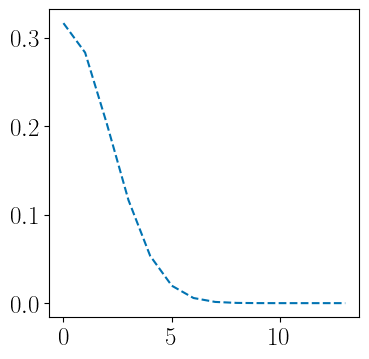

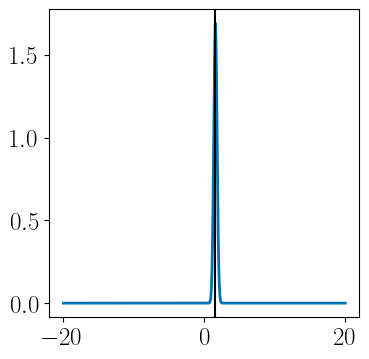

In [22]:
psi0, qpc_init = gen_QPC_dot_basis(L_qpc, centered_at, band_width, K0, ddot,af,bf,phi)
# create the fermion operator list
c_list = [fdestroy(L,i) for i in range(0,L)]

# we can also calcualte the fourier transform of the initial gaussian to see
# the momentum distribution
k_arr = np.linspace(-20,20,500)
Psi0k = (band_width**2/np.pi)**(1/4)*np.exp(-(0.5*band_width**2)*(k_arr-K0)**2 + 1j*k_arr*centered_at)

# visualize the initial condition of the qpc
fig, ax = plt.subplots(1,1,figsize=(4,4))

ax.plot(range(0,L_qpc),np.abs(qpc_init)**2, linestyle = "dashed")

fig, ax = plt.subplots(1,1,figsize=(4,4))

ax.plot(k_arr,np.abs(Psi0k)**2, linestyle = "solid", linewidth=2)
ax.axvline(K0,c='black')

In [23]:
np.shape(psi0)

(65536, 1)

# Solution

In [7]:
(2**2)*(2**L_qpc)

65536

In [8]:
# create the hamiltonian start with qpc
H_QC = get_qpc_H(c_list, L ,L_qpc,J)

# double dot H
Hdot = -t*(c_list[-1].dag()*c_list[-2] + c_list[-2].dag()*c_list[-1])

# interaction H it couples QPC momentum to qubit density at site 1 (set second last in the chain)
Hint =  Omega*c_list[-2].dag()*c_list[-2]*( c_list[bond_index].dag()*c_list[bond_index+1] +
                                          c_list[bond_index+1].dag()*c_list[bond_index])

H = H_QC + Hdot + Hint

print(H_QC.isherm, Hdot.isherm, Hint.isherm, H.isherm)

# get the operators needed for lindbladian 
# hrtr we don't really want dephasing but just put it there for now
collapse_ops, expect_ops = create_lindblad_op(L, c_list, gamma)
# add the energy to also track it
expect_ops.append(H)

times = np.linspace(0.0, max_t, tsteps)
# solve 
result = sesolve(H, psi0, times, e_ops=expect_ops,options={"store_states": True})

print(result)



True True True True
<Result
  Solver: sesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.00016808509826660156
    preparation time: 0.02330493927001953
    run time: 0.7371671199798584
    solver: 'Schrodinger Evolution'
  Time interval: [0.0, 9.0] (300 steps)
  Number of e_ops: 17
  States saved.
>


# Analysis

In [9]:
"""# for plotting SMALL Hamiltonians
fig, ax = hinton(H)
ax.tick_params(axis='both', which='major', labelsize = 4)
ax.tick_params(axis='x', rotation=90)
# plt.savefig("H.png", dpi =500)"""

'# for plotting SMALL Hamiltonians\nfig, ax = hinton(H)\nax.tick_params(axis=\'both\', which=\'major\', labelsize = 4)\nax.tick_params(axis=\'x\', rotation=90)\n# plt.savefig("H.png", dpi =500)'

In [10]:
# exclude the sites at Lp/2 and Lp/2 +1 where the bond is located
n_left = np.sum(result.expect[:bond_index], axis=0)
# the minus 3 is because we  leave out the energy and dot occupations
n_right = np.sum(result.expect[bond_index+2:-3], axis=0)
# occupation in the bond
n_bond = result.expect[int(bond_index)] + result.expect[bond_index+1] 


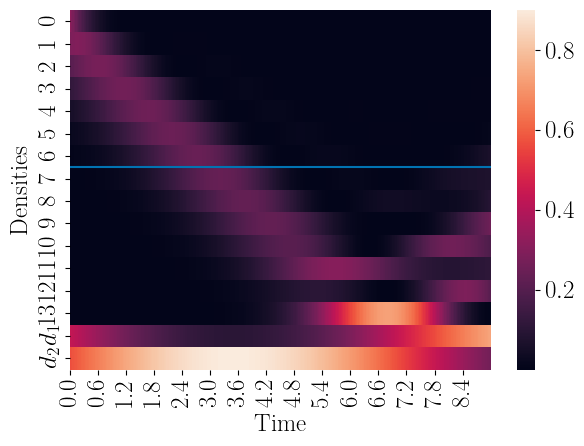

In [11]:
# plot the occupations as a heatmap with lattice site in the y axis and time on the x
ax = sns.heatmap(result.expect[:-1],)
ax.set_xlabel("Time")
ax.set_ylabel("Densities")

# plot time or arrival in index coordinates
delta_tau = times[1]- times[0]

ax.axhline(bond_index)

# lattice ticks
site_ticks = list(range(0,L_qpc)) + [r"$d_1$",r"$d_2$"]
tick_posy = np.asarray(range(0,len(site_ticks))) + 0.5
ax.set_yticks(tick_posy,site_ticks);

# time ticks
tick_posx = np.arange(0,len(times),20)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)
ax.set_xticks(tick_posx,xtick_label);

plt.tight_layout()

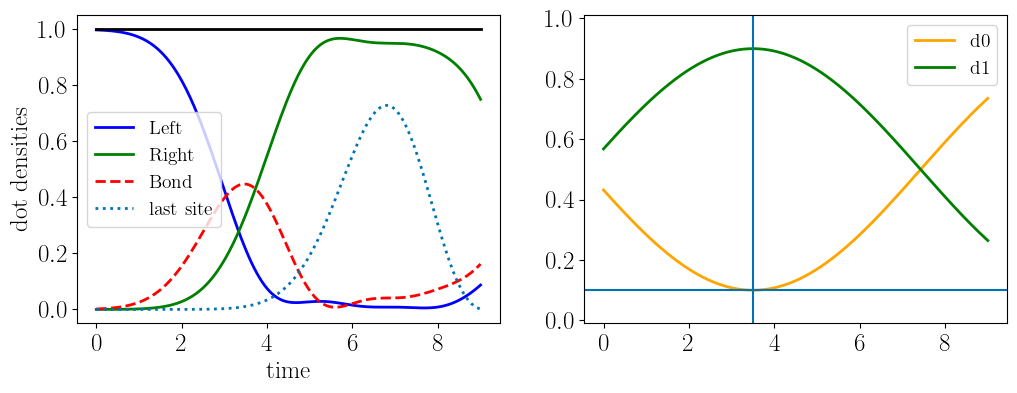

In [12]:
τb = bond_index/(2*J[0]*np.sin(K0))


# exclude the sites at Lp/2 and Lp/2 +1 where the bond is located
n_left = np.sum(result.expect[:bond_index], axis=0)
# the minus 3 is because we  leave out the energy and dot occupations
n_right = np.sum(result.expect[bond_index+2:-3], axis=0)
# occupation in the bond
n_bond = result.expect[int(bond_index)] + result.expect[bond_index+1] 

fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(times, n_left, label="Left", c='blue', linewidth=2)
ax[0].plot(times,n_right,label="Right", c='green',linewidth=2)
ax[0].plot(times,n_bond,label="Bond", linestyle="dashed", c='red',linewidth=2)
ax[0].plot(times,result.expect[-4],label="last site", linestyle="dotted",linewidth=2)
ax[0].plot(times,n_left+n_right+n_bond, c = 'black',linewidth=2)
ax[0].set_xlabel("time")
ax[0].set_ylabel("Numeric Densities")
ax[0].legend()

ax[1].plot(times, result.expect[-3], label="d0", c='orange', linewidth=2)
ax[1].plot(times, result.expect[-2], label="d1", c='green', linewidth=2)
ax[1].axvline(τb)
ax[1].axhline(af**2)
ax[1].set_ylim(-0.01, 1.01)


ax[0].set_xlabel("time")
ax[0].set_ylabel("dot densities")
ax[1].legend()


## Entanglement Meassures

In [13]:
purity_list = []
entropy_list = []
rho_list = []
# skip some times otherwise its too heavy
tskip=20
state_arr = result.states[0::tskip]

for ti in range(0,len(state_arr)):
    # DD reduced density matrix
    # rho_DD = get_partial_trace(state_arr[ti], L_qpc+2)
    # transform to sparse
    state_spa = state_arr[ti]
    state_spa.data = data.to(data.CSR, state_spa.data)
    rho = state_spa*state_spa.dag()
    rho_DD = rho.ptrace(sel=[L-2,L-1])
    # purity
    purity_list.append((rho_DD**2).tr())
    entropy_list.append(entropy_vn(rho_DD, sparse=True))
    rho_list.append(rho_DD)

3.910447386227442e-07


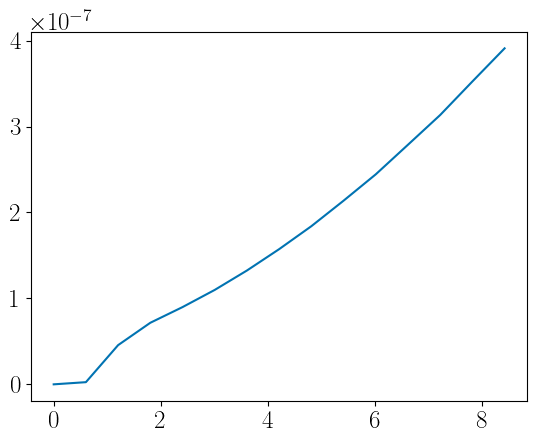

In [14]:
print(max(entropy_list))
plt.plot(times[0::tskip],entropy_list)

## Bloch Sphere

two ideas: either trace out dot 2 or just isolate the block corresponding to the actual two state system. Remember that here the density matrix of the double dot is not sxs but 4x4 beacuse in each lattice there is an occupied and unoccupied state. For the spinless case this measn that there are surplus degrees of freedom but this will be useul for spin cases.

## Rabi oscillations at many initial conditions

Testing if the arbitrary init works

1.5707963267948966
1.2566370614359172
1.0471975511965976
0.7853981633974483
0.6283185307179586
0.5235987755982988


(-0.01, 1.01)

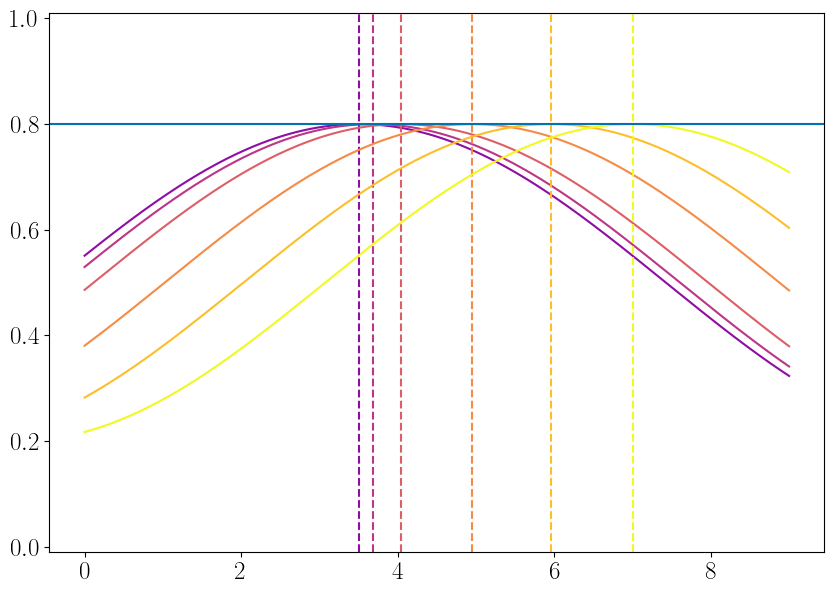

In [16]:
# generate a longer time to look at the oscillations
kp_list = [np.pi/2,np.pi/(2.5),np.pi/3,np.pi/4, np.pi/5,  np.pi/6]
af = np.sqrt(0.8)
bf = np.sqrt(1-af**2)
ddot = "momentum"

colors = plt.cm.plasma(np.linspace(0.3,1,len(kp_list)))
plt.figure(figsize=(10,7))

for i in range(0, len(kp_list)):
    K0 = kp_list[i]
    print(K0)
    psi0, qpc_init = gen_QPC_dot_basis(L_qpc, centered_at, band_width, K0, ddot, af, bf, phi)
    
    # create the fermion operator list
    c_list = [fdestroy(L,i) for i in range(0,L)]
    # create the hamiltonian start with qpc
    H_QC = get_qpc_H(c_list, L ,L_qpc,J)
    Hdot = -t*(c_list[-1].dag()*c_list[-2] + c_list[-2].dag()*c_list[-1])
    Hint =  Omega*c_list[-2].dag()*c_list[-2]*( c_list[bond_index].dag()*c_list[bond_index+1] +
                                              c_list[bond_index+1].dag()*c_list[bond_index])
    H = H_QC + Hdot  + Hint

    collapse_ops, expect_ops = create_lindblad_op(L, c_list, gamma)
    expect_ops.append(H)
    times = np.linspace(0.0, max_t, tsteps)
    
    # solve 
    result = sesolve(H, psi0, times, e_ops=expect_ops,options={"store_states": True})    
    
    plt.plot(times,result.expect[-3], c=colors[i])

    # plot the approx time to bond
    Taub = bond_index/(2*J[1]*np.sin(K0))

    plt.axvline(Taub, linestyle="dashed",c=colors[i])

plt.axhline(af**2)
plt.ylim(-0.01, 1.01)

